In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
from tensorflow.keras import layers, Input, optimizers, losses, activations, models, applications
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate, BatchNormalization, GlobalAveragePooling2D, Activation

In [2]:
TARGET_SIZE = 256
train_datagen = ImageDataGenerator(rescale=1./255.,
                                     featurewise_center=True,
                                     validation_split = 0.08,
                                   zoom_range = 0.07
                                    )
test_datagen = ImageDataGenerator(rescale= 1./255)
train_data = train_datagen.flow_from_directory(
    '../input/covidradiography2/COVID-19 Radiography Database/Train',
    class_mode="sparse",
    batch_size=32,
    target_size=(TARGET_SIZE,TARGET_SIZE),
    shuffle=True,
    subset="training",
)

validation_data = train_datagen.flow_from_directory(
    '../input/covidradiography2/COVID-19 Radiography Database/Train',
    class_mode="sparse",
    batch_size=32,
    target_size=(TARGET_SIZE, TARGET_SIZE),
    shuffle=True,
    subset="validation",
)

test_data = test_datagen.flow_from_directory(
    '../input/covidradiography2/COVID-19 Radiography Database/Test',
    class_mode="sparse",
    batch_size=32,
    target_size=(TARGET_SIZE, TARGET_SIZE),
    shuffle=False,
)

Found 3290 images belonging to 3 classes.
Found 284 images belonging to 3 classes.
Found 312 images belonging to 3 classes.


In [3]:
base_model = tf.keras.applications.DenseNet169(weights="imagenet",include_top=False,input_shape=(TARGET_SIZE,TARGET_SIZE, 3))
y1 = base_model.output
y = GlobalAveragePooling2D()(y1)
x = Dense(512, activation='relu')(y)
x=Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)

model=Sequential()
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.SGD(learning_rate=0.1),metrics=['accuracy'])
model.summary()
model_save = ModelCheckpoint('weights.h5', 
                              save_best_only = True, 
                              save_weights_only = True,
                              monitor = 'val_loss', 
                              mode = 'min', verbose = 1)


51879936/51877672 [==============================] - 1s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
______________________

In [4]:
EPOCHS = 15
history = model.fit_generator(
     train_data,
     steps_per_epoch=train_data.samples//train_data.batch_size,
     epochs = EPOCHS,
     validation_data = validation_data,
     validation_steps=validation_data.samples//validation_data.batch_size,
     callbacks = [model_save])

Epoch 1/15
102/102 [==============================] - ETA: 0s - loss: 0.3795 - accuracy: 0.8735
Epoch 00001: val_loss improved from inf to 1.04616, saving model to weights.h5
102/102 [==============================] - 145s 1s/step - loss: 0.3795 - accuracy: 0.8735 - val_loss: 1.0462 - val_accuracy: 0.6367
Epoch 2/15
102/102 [==============================] - ETA: 0s - loss: 0.1390 - accuracy: 0.9561
Epoch 00002: val_loss improved from 1.04616 to 0.25613, saving model to weights.h5
102/102 [==============================] - 101s 992ms/step - loss: 0.1390 - accuracy: 0.9561 - val_loss: 0.2561 - val_accuracy: 0.8906
Epoch 3/15
102/102 [==============================] - ETA: 0s - loss: 0.1271 - accuracy: 0.9616
Epoch 00003: val_loss improved from 0.25613 to 0.05990, saving model to weights.h5
102/102 [==============================] - 102s 1s/step - loss: 0.1271 - accuracy: 0.9616 - val_loss: 0.0599 - val_accuracy: 0.9766
Epoch 4/15
102/102 [==============================] - ETA: 0s - loss

In [5]:
pred = model.predict_generator(test_data)
y_pred = pred.argmax(axis=-1)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2
 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2]


In [6]:
model.evaluate(test_data)

10/10 [==============================] - 4s 402ms/step - loss: 0.0460 - accuracy: 0.9872


[0.04603487253189087, 0.9871794581413269]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


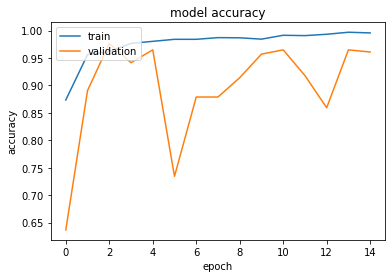

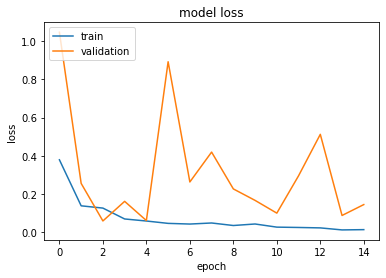

In [7]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Confusion Matrix
[[104   0   0]
 [  0 103   1]
 [  1   2 101]]
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    0.99048   1.00000   0.99522       104
           1    0.98095   0.99038   0.98565       104
           2    0.99020   0.97115   0.98058       104

    accuracy                        0.98718       312
   macro avg    0.98721   0.98718   0.98715       312
weighted avg    0.98721   0.98718   0.98715       312



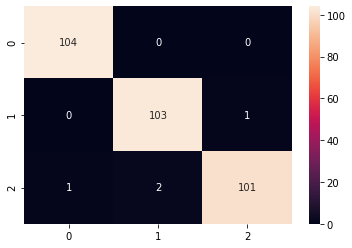

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
cm = confusion_matrix(test_data.classes, y_pred)
print(cm)
print(sns.heatmap(confusion_matrix(test_data.classes, y_pred),annot=True, fmt= "d"))
print(classification_report(test_data.classes, y_pred, digits=5))

In [9]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print(np.mean(recall))
print(np.mean(precision))

0.9871794871794872
0.9872082166199814
